# SeeFood

In [1]:
import glob 
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import datasets, layers, models
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import PIL

Using TensorFlow backend.


In [2]:
def load_images2(paths, dim, label_value):
    imgs, labels = [], []
    
    for idx, path in enumerate(paths):
        for pic in glob.glob(path, recursive=True):
            img = load_img(pic, target_size=dim)
            imgs.append(np.array(img)/255.0)
            labels.append(label_value[idx])
    
    features = np.array([img_to_array(img) for img in imgs])
    
    return features, np.array(labels)
    

In [3]:
# Specify paths to the data
hot_dog_path = '..\\dataset\\hot_dog\\**/*.jpg'
not_hotdog_path = '..\\dataset\\not_hot_dog\\**/*.jpg'

image_size = 32

features, labels = load_images2([hot_dog_path, not_hotdog_path], (image_size, image_size), [1,0])


print(features.shape)
    
    

(998, 32, 32, 3)


In [4]:

# Create a random array from [0 -> len of features and labels]
s = np.arange(features.shape[0])
# shuffle it
np.random.shuffle(s)

# use that array to shuffle features and labels
# the same way so we don't lose information
features = features[s]
labels = labels[s]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)
print(features[0].shape)


(32, 32, 3)


### Verify the data


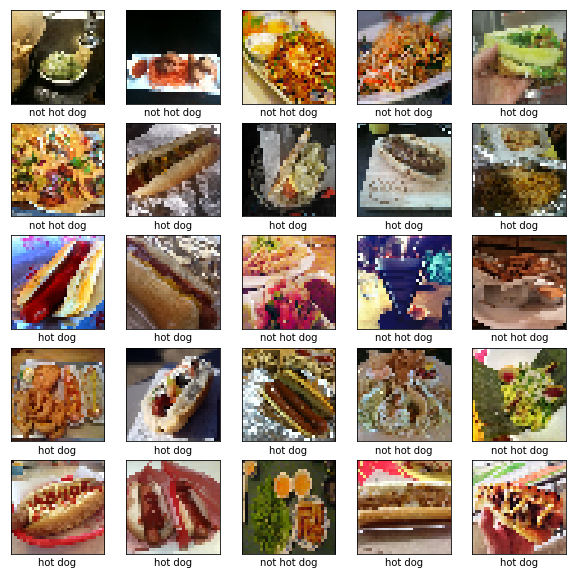

In [5]:
plt.figure(figsize=(10,10))
named_labels = ["not hot dog", "hot dog"]

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(features[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(named_labels[labels[i]])
plt.show()

In [6]:
def rotateImage(img, angle):
    (rows, cols, ch) = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    return cv2.warpAffine(img, M, (cols,rows))

def augment_image(img):
    angle = np.random.randint(0, 360)
    #img = cv2.blur(img,(5,5))
    #print(img)
    #print("OVOO HJE", img.shape)
    return rotateImage(img,angle)
    



In [7]:
def augment_train_set(train_size):
    xxx, yyy = [], []
    for i in range(train_size - X_train.shape[0]):
        rand = np.random.randint(0, X_train.shape[0])
        img = augment_image(np.copy(X_train[rand]))
        xxx.append(img)
        yyy.append(y_train[rand])

    print(y_train.shape, np.array(yyy).shape)
    xxx = np.concatenate((X_train, np.array(xxx)))
    yyy = np.concatenate((y_train, np.array(yyy)))  
    
    return xxx, yyy 
    

In [8]:
def augment_train_set2(train_size, X_train, y_train):
    m = np.zeros((train_size,image_size,image_size, 3))
    print(m.shape)
    print(X_train.shape)
    m[:X_train.shape[0]] = X_train
    shp = X_train.shape[0]
    for i in range(train_size - X_train.shape[0]):
        rand = np.random.randint(0, X_train.shape[0])
        img = augment_image(np.copy(X_train[rand]))
        m[i+shp] = img
        #X_train = np.append(X_train, [img], axis=0)
        y_train = np.append(y_train, y_train[rand])
    
    return m, y_train 

In [9]:
X_train, y_train = augment_train_set2(25000, X_train, y_train)
print(X_train.shape)

(25000, 32, 32, 3)
(668, 32, 32, 3)
(25000, 32, 32, 3)


In [17]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

### Add Dense layer

In [18]:
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's see the model architecture:

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 64)          0

In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 330 samples
Epoch 1/10
25000/25000 [==============================] - 12s 468us/sample - loss: 0.6522 - accuracy: 0.6072 - val_loss: 0.5731 - val_accuracy: 0.7212
Epoch 2/10
25000/25000 [==============================] - 12s 462us/sample - loss: 0.5580 - accuracy: 0.7052 - val_loss: 0.5949 - val_accuracy: 0.7182
Epoch 3/10
25000/25000 [==============================] - 12s 465us/sample - loss: 0.4374 - accuracy: 0.7874 - val_loss: 0.5724 - val_accuracy: 0.7545
Epoch 4/10
25000/25000 [==============================] - 12s 486us/sample - loss: 0.3377 - accuracy: 0.8518 - val_loss: 0.7441 - val_accuracy: 0.7515
Epoch 5/10
25000/25000 [==============================] - 11s 460us/sample - loss: 0.2512 - accuracy: 0.8956 - val_loss: 0.8411 - val_accuracy: 0.7455
Epoch 6/10
25000/25000 [==============================] - 11s 456us/sample - loss: 0.1919 - accuracy: 0.9211 - val_loss: 0.8365 - val_accuracy: 0.7455
Epoch 7/10
25000/25000 [======================

330/1 - 0s - loss: 0.9060 - accuracy: 0.7485


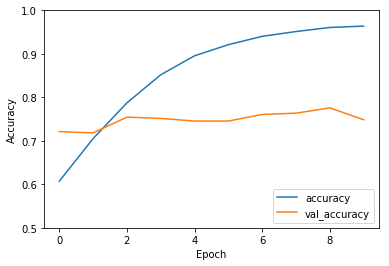

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
plt.figure(figsize=(16,16))
rez = model.predict(X_test[:25])
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    plt.xlabel(named_labels[np.argmax(rez[i])])
plt.show()